In [2]:
import os
import pandas as pd
import glob

# 设置文件夹路径
folder_path = 'Data/London2021'

# 获取所有包含"metropolitan-street"的CSV文件的路径
all_files = glob.glob(os.path.join(folder_path, '*', '*-street*.csv'))

# 按文件名排序，确保月份顺序正确
all_files.sort()

# 创建一个空列表来存储每个CSV文件的数据
df_list = []

# 读取每个CSV文件并添加到列表中
for file in all_files:
    df = pd.read_csv(file)
    df_list.append(df)

# 将所有数据框连接成一个大的数据框
combined_df = pd.concat(df_list, ignore_index=True)

# 将合并后的数据保存为一个新的CSV文件
combined_df.to_csv('England_crime_data_2021.csv', index=False)

print("所有包含'metropolitan-street'的CSV文件已合并完成。")

所有包含'metropolitan-street'的CSV文件已合并完成。


In [44]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

# 读取CSV文件
csv_file_path = 'England_crime_data_2021.csv'
combined_df = pd.read_csv(csv_file_path)

# 读取Shapefile文件
lsoa_gdf = gpd.read_file('Census_MSOA/England_MSOA.shp')

# 检查并设置LSOA数据的CRS
if lsoa_gdf.crs is None:
    print("警告: Shapefile没有定义CRS。假设它是EPSG:27700 (British National Grid)")
    lsoa_gdf.set_crs(epsg=27700, inplace=True)
else:
    print(f"Shapefile的原始CRS是: {lsoa_gdf.crs}")

# 确保LSOA数据使用EPSG:27700
lsoa_gdf = lsoa_gdf.to_crs(epsg=27700)

# 创建点几何对象，并明确指定初始CRS
geometry = [Point(xy) for xy in zip(combined_df['Longitude'], combined_df['Latitude'])]
crime_gdf = gpd.GeoDataFrame(combined_df, geometry=geometry, crs="EPSG:4326")

# 将犯罪数据转换为EPSG:27700
crime_gdf = crime_gdf.to_crs(epsg=27700)

# 执行空间连接
joined_gdf = gpd.sjoin(crime_gdf, lsoa_gdf, how="inner", predicate="within")

# 计算每个LSOA的犯罪数量
crime_count = joined_gdf.groupby('index_right').size().reset_index(name='crime_count')
lsoa_with_crime_count = lsoa_gdf.merge(crime_count, left_index=True, right_on='index_right', how='left')
lsoa_with_crime_count['crime_count'] = lsoa_with_crime_count['crime_count'].fillna(0)

# 打印结果摘要
print(f"总LSOA数量: {len(lsoa_with_crime_count)}")
print(f"有犯罪记录的LSOA数量: {len(lsoa_with_crime_count[lsoa_with_crime_count['crime_count'] > 0])}")
print(f"总犯罪数量: {lsoa_with_crime_count['crime_count'].sum()}")
print(f"平均每个LSOA的犯罪数量: {lsoa_with_crime_count['crime_count'].mean():.2f}")

# 保存结果（可选）
# lsoa_with_crime_count.to_file('LSOA_with_crime_count_EPSG27700.shp')

Shapefile的原始CRS是: EPSG:27700
总LSOA数量: 7264
有犯罪记录的LSOA数量: 7166
总犯罪数量: 5718887.0
平均每个LSOA的犯罪数量: 787.29


In [3]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

# 读取CSV文件
csv_file_path = 'England_crime_data_2021.csv'
combined_df = pd.read_csv(csv_file_path)

# 读取Shapefile文件
lsoa_gdf = gpd.read_file('Census_MSOA/England_MSOA.shp')

# 检查并设置LSOA数据的CRS
if lsoa_gdf.crs is None:
    print("警告: Shapefile没有定义CRS。假设它是EPSG:27700 (British National Grid)")
    lsoa_gdf.set_crs(epsg=27700, inplace=True)
else:
    print(f"Shapefile的原始CRS是: {lsoa_gdf.crs}")

# 确保LSOA数据使用EPSG:27700
lsoa_gdf = lsoa_gdf.to_crs(epsg=27700)

# 创建点几何对象，并明确指定初始CRS
geometry = [Point(xy) for xy in zip(combined_df['Longitude'], combined_df['Latitude'])]
crime_gdf = gpd.GeoDataFrame(combined_df, geometry=geometry, crs="EPSG:4326")

# 将犯罪数据转换为EPSG:27700
crime_gdf = crime_gdf.to_crs(epsg=27700)

# 执行空间连接
joined_gdf = gpd.sjoin(crime_gdf, lsoa_gdf, how="inner", predicate="within")

# 计算每个LSOA的总犯罪数量
crime_count = joined_gdf.groupby('index_right').size().reset_index(name='total_crime_count')

# 计算每个LSOA的每种犯罪类型的数量
crime_type_count = joined_gdf.groupby(['index_right', 'Crime type']).size().unstack(fill_value=0)

# 合并总犯罪数量和各类型犯罪数量
lsoa_crime_stats = crime_count.merge(crime_type_count, left_on='index_right', right_index=True)

# 计算每种犯罪类型的比例
for crime_type in crime_type_count.columns:
    lsoa_crime_stats[f'{crime_type}_ratio'] = lsoa_crime_stats[crime_type] / lsoa_crime_stats['total_crime_count']

# 将结果与LSOA地理数据合并
lsoa_with_crime_stats = lsoa_gdf.merge(lsoa_crime_stats, left_index=True, right_on='index_right', how='left')

# 填充缺失值
lsoa_with_crime_stats = lsoa_with_crime_stats.fillna(0)

# 打印结果摘要
print(f"总LSOA数量: {len(lsoa_with_crime_stats)}")
print(f"有犯罪记录的LSOA数量: {len(lsoa_with_crime_stats[lsoa_with_crime_stats['total_crime_count'] > 0])}")
print(f"总犯罪数量: {lsoa_with_crime_stats['total_crime_count'].sum()}")
print(f"平均每个LSOA的犯罪数量: {lsoa_with_crime_stats['total_crime_count'].mean():.2f}")

# 打印每种犯罪类型的总数和总体比例
total_crimes = lsoa_with_crime_stats['total_crime_count'].sum()
print("\n各类型犯罪统计:")
for crime_type in crime_type_count.columns:
    type_total = lsoa_with_crime_stats[crime_type].sum()
    type_ratio = type_total / total_crimes
    print(f"{crime_type}: 数量 = {type_total}, 比例 = {type_ratio:.2%}")

# 保存结果（可选）
# lsoa_with_crime_stats.to_file('LSOA_with_crime_stats_EPSG27700.shp')

Shapefile的原始CRS是: EPSG:27700
总LSOA数量: 6856
有犯罪记录的LSOA数量: 6758
总犯罪数量: 5401163.0
平均每个LSOA的犯罪数量: 787.80

各类型犯罪统计:
Anti-social behaviour: 数量 = 1242684.0, 比例 = 23.01%
Bicycle theft: 数量 = 65010.0, 比例 = 1.20%
Burglary: 数量 = 209595.0, 比例 = 3.88%
Criminal damage and arson: 数量 = 422859.0, 比例 = 7.83%
Drugs: 数量 = 151596.0, 比例 = 2.81%
Other crime: 数量 = 89628.0, 比例 = 1.66%
Other theft: 数量 = 334345.0, 比例 = 6.19%
Possession of weapons: 数量 = 35686.0, 比例 = 0.66%
Public order: 数量 = 451981.0, 比例 = 8.37%
Robbery: 数量 = 49361.0, 比例 = 0.91%
Shoplifting: 数量 = 213401.0, 比例 = 3.95%
Theft from the person: 数量 = 63576.0, 比例 = 1.18%
Vehicle crime: 数量 = 287591.0, 比例 = 5.32%
Violence and sexual offences: 数量 = 1783850.0, 比例 = 33.03%


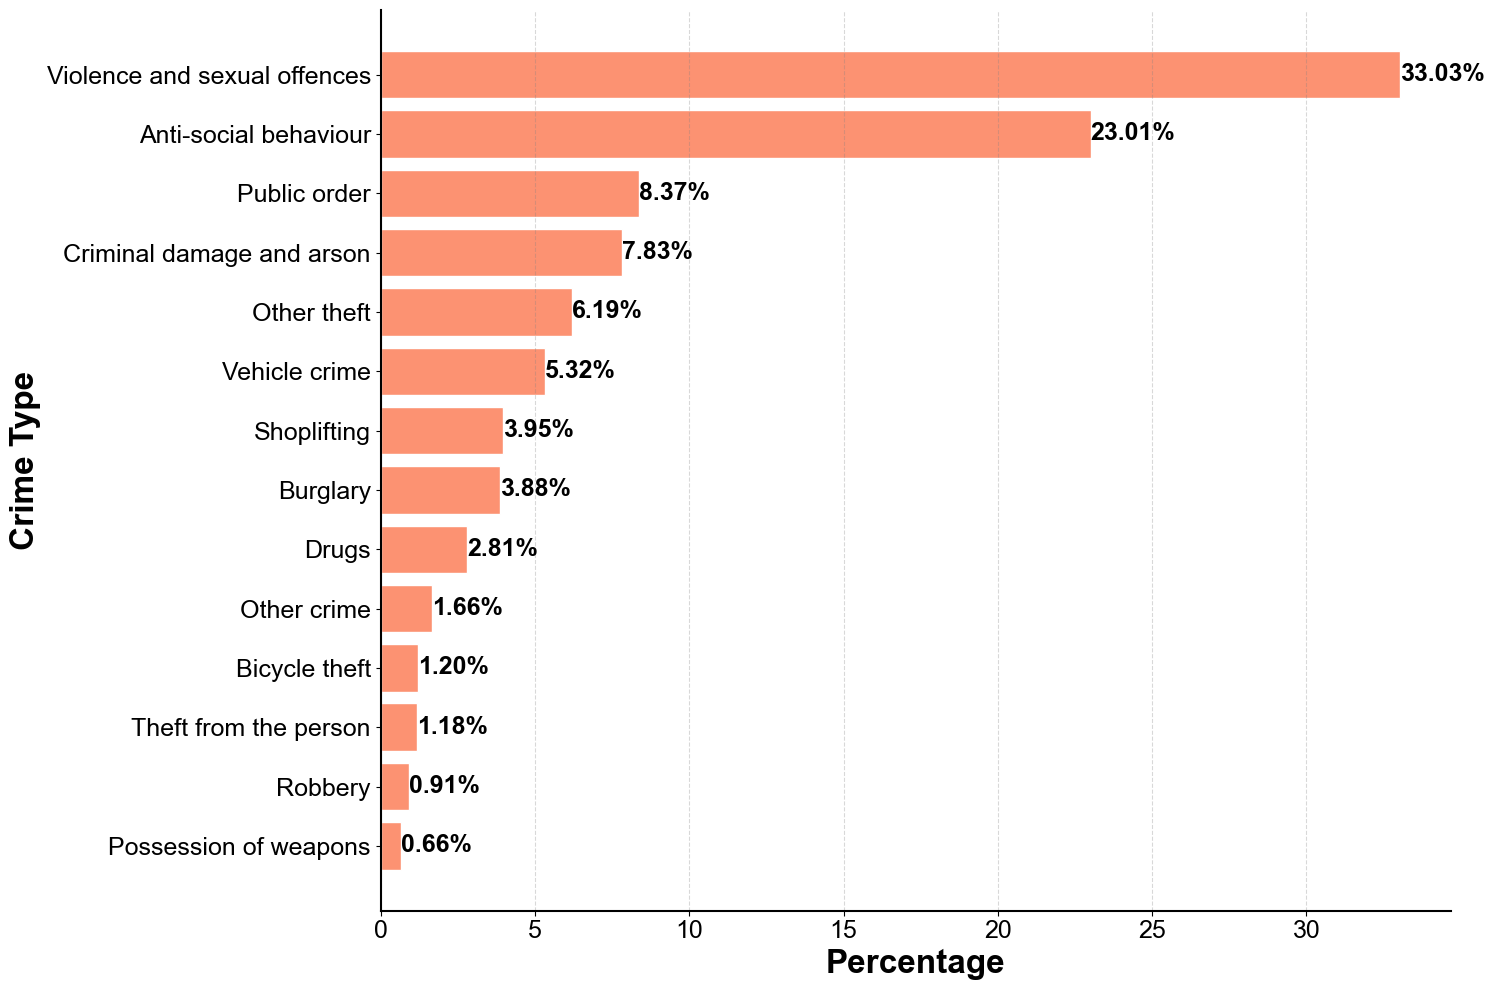

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# 设置字体
plt.rcParams['font.family'] = 'Arial'

# 假设 crime_type_ratios_sorted 已经定义
# 选择前15种犯罪类型（如果超过15种）
top_crimes = crime_type_ratios_sorted.head(20)

# 创建图表
fig, ax = plt.subplots(figsize=(15, 10))

# 绘制水平条形图
bars = ax.barh(top_crimes.index, top_crimes.values * 100, color='#fc9272', edgecolor='white')

# 添加数值标签
for bar in bars:
    width = bar.get_width()
    ax.text(width, bar.get_y() + bar.get_height()/2, f'{width:.2f}%',
            ha='left', va='center', fontweight='bold', fontsize=18)

# 设置标题和标签
ax.set_xlabel('Percentage', fontsize=24, fontweight='bold')
ax.set_ylabel('Crime Type', fontsize=24, fontweight='bold')

# 调整刻度标签
ax.tick_params(axis='both', which='major', labelsize=18)

# 添加网格线
ax.grid(axis='x', linestyle='--', alpha=0.3, color='gray')

# 移除上边框和右边框
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# 加粗左边框和下边框
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)

# 反转y轴，使最高百分比在顶部
ax.invert_yaxis()

# 调整布局
plt.tight_layout()

# 保存图形
plt.savefig('crime_types_distribution_horizontal_bar.png', dpi=600, bbox_inches='tight')
plt.show()

In [38]:
import pandas as pd
import numpy as np

# 加载原始数据
file_path = 'test_csv.csv'
data = pd.read_csv(file_path)

# 定义要使用的变量
variable_mapping = {
    'Aged 60 years and over': 'AGE_60',
    'Migrant from within or outside the UK': 'MIG',
    'MSOADECILE': 'D_IMD',
    '1 bedroom': 'BED_1'
}

selected_vars_vif = list(variable_mapping.values())
dependent_var = 'crime_rate'

# 重命名列
data = data.rename(columns=variable_mapping)

# 保存原始数据的标准差
original_std = data[selected_vars_vif + [dependent_var]].std()

# 标准化数据
for col in selected_vars_vif + [dependent_var]:
    data[col] = (data[col] - data[col].mean()) / data[col].std()

# 加载z-score.csv
z_scores = pd.read_csv('z-score.csv')
z_scores = z_scores.set_index('Variable')

# 计算原始回归系数
def calculate_original_coefficients(z_coefficients, y_std, x_std):
    return z_coefficients * (y_std / x_std)

# 为OLS, SLM, SEM分别计算原始系数
models = ['OLS', 'SLM', 'SEM']
results = {}

for model in models:
    z_coeffs = z_scores[model]
    
    original_coeffs = calculate_original_coefficients(
        z_coeffs[selected_vars_vif],
        original_std[dependent_var],
        original_std[selected_vars_vif]
    )
    
    results[model] = original_coeffs

# 将所有结果合并到一个DataFrame中
final_results = pd.DataFrame(results)
final_results.index.name = 'Variable'

# 保存结果到CSV文件
final_results.to_csv('original_coefficients.csv')

print("原始系数已保存到 'original_coefficients.csv' 文件中。")
print("\n最终结果预览：")
print(final_results)

原始系数已保存到 'original_coefficients.csv' 文件中。

最终结果预览：
               OLS        SLM       SEM
Variable                               
AGE_60    0.477912   1.836680  0.028112
MIG       2.526853   3.951079  2.572796
D_IMD    -7.865820 -13.758334 -6.851760
BED_1     3.545340   6.077726  3.958025
